In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as pyplotcolors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.sparse.linalg import svds
%matplotlib inline

In [8]:
import tools
reload(tools)
from tools import *

In [ ]:
mypals = {
    "beige-purple": {"npal": 5, "start": 2.4, "rot": 0.8, "dark": 0., "light": 0.8, "reverse": 1},
}

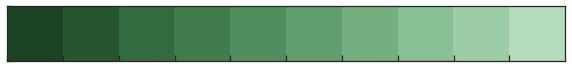

In [4]:
import seaborn as sns
import itertools
sns.set()
sns.set_style("white")
sty = sns.set_style("ticks",{"xtick.major.size":0.8,"ytick.major.size":0.8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
# sns.palplot(sns.color_palette("cubehelix", 8))
# sns.set_palette("cubehelix")

npal = 10
shift = 1
stride = 1
start = 2
rot = 30.0
gamma = 1.0
dark = 0.2
light = 0.8
palnamething = sns.cubehelix_palette(npal,start=start,rot=rot,light=light,dark=dark,reverse=True, gamma=gamma)
# palnamething = sns.color_palette("Paired")
# palnamething = sns.color_palette("bright")
sns.set_palette(palnamething, npal)
pal = sns.color_palette(palnamething, npal)
palette = itertools.cycle(pal)
sns.palplot(pal)

for _ in range(shift):
    next(palette)
coldict = {}
for i in range(npal):
    for s in range(1,stride):
        next(palette)
    coldict.update({i:next(palette)})

In [49]:
rodcol = coldict[0]
rdotcol = coldict[5]

In [5]:
# PCA params
#
latticemode = True
use_scaling = True
use_xyth = False
use_quadrature = True

In [6]:
# Colouring method
#
use_kmeans = False
use_dims = False # color by first 3 dims
use_1D = True
Dim = 2 # 0 is first dim

# For dim coloring
# maxsats = 0.7*(np.max(Y[:,:3],axis=0) - np.min(Y[:,3],axis=0))
# minsats = np.min(Y[:,:3],axis=0)


In [ ]:
# hyperparams
NBRS = np.array([10,15,20,30])
methods = ["random", "radial", "angular", "polar"]
nmethod = len(methods)
n_nbr = 36
nft = n_nbr*3 if use_xyth else n_nbr
run = "xtud"
method = methods[3]

source = "/home/walterms/mcmd/nn/data/pca/"
fname = ""
if latticemode:
    prestr = source+"lat_nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = prestr+"_"+str(n_nbr)+"_"+str(method)
else:
    prestr = source+"nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = source+"nbrs_"+run+"_"+str(n_nbr)+"_"+str(method)

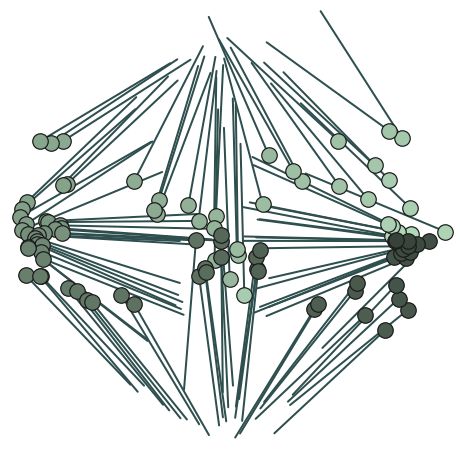

In [181]:
# TAKEN FROM RODPLOT
#
# To view a single unprocessed snap
#
f = plt.figure(frameon=False);
plt.xticks([]);
plt.yticks([]);
plt.gcf().set_size_inches(8,8);

imgnames = []
holefactor = 0.
source_dir = "/home/walterms/project/walterms/circ_mcmd/output/defects/"
imgnames = ["minusone_reruns"]
nrod = 10**2

imgdir = "/home/walterms/project/walterms/mcmd/imgs/paperimgs/"
fRot = 0
if imgnames[0].startswith("U"):
    fRot = 2
halfL = 1.0/2

iSnap = 200

for imgname in imgnames:
    f.clf();

    # Count num blocks
    Nblock = 0
# #     iSnap = -1
    dfile = open(source_dir+imgname, "r")
    for line in dfile.readlines():
        if line == "\n": Nblock+=1
    dfile.seek(0)
    if iSnap == -1: iSnap = Nblock-1


    if not (dfile.readline()[0].isalpha()): dfile.seek(0)
    cntSnap = 0
    
    rods = np.zeros((nrod,7)) # coords
    rcount = 0
    for line in dfile.readlines():
        if cntSnap == iSnap:
            
            if line == "\n" or line.startswith("label"): break
            l = [float(x) for x in line.split()]
            x,y,th = l[2],l[3],l[4]
            # Note th=0 is along the y-axis
            x1 = x - halfL*sin(th)
            y1 = y + halfL*cos(th)
            x2 = x + halfL*sin(th)
            y2 = y - halfL*cos(th)

            # Rotations
            th_ = fRot*np.pi*0.5
            x_ = cos(th_)*x - sin(th_)*y
            y_ = sin(th_)*x + cos(th_)*y
            x1_ = cos(th_)*x1 - sin(th_)*y1
            y1_ = sin(th_)*x1 + cos(th_)*y1
            x2_ = cos(th_)*x2 - sin(th_)*y2
            y2_ = sin(th_)*x2 + cos(th_)*y2                

            rods[rcount] = [x_,y_,x1_,y1_,x2_,y2_,0.]
            rcount+=1
        else: 
            if line == "\n": cntSnap+=1
                
    # Sort rods based on polar position
    phi = np.arctan2(rods[:,1],rods[:,0])
    phi = np.where(phi < 0., phi+twopi, phi)
    rods[:,-1] = phi
    rods = rods[rods[:,-1].argsort()]

    for irod,rod in enumerate(rods):
        x1,y1,x2,y2 = rod[2:6]
        pointcolor = tuple([cc*(1. - 0.7*irod/float(nrod)) for cc in coldict[8]])
        plotLine(x1,y1,x2,y2, c="darkslategray", lw=2.0);
        plt.scatter(x1,y1,s=240,c=pointcolor,edgecolors="k",linewidths=1.2,zorder=10)

                
    # For circles
    dfile.seek(0)
    ln = dfile.readline().split("|")
    edge = 0.
    holerad = 0.
    for s in ln:
        if "boxEdge" in s:
            edge = float(s.split()[1])
            
        if "defect_radius" in s:
            holerad = float(s.split()[1])
    dfile.close()

    radius = edge/3.
#     radius = holerad
#     boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2);
    boundary = plt.Circle((0, 0), radius, color='k', fill=False);
#     innercirc = plt.Circle((0, 0), holerad, color='seagreen', linestyle="--", fill=False, linewidth=2.0);

#     plt.gca().add_artist(boundary);
#     plt.gca().add_artist(innercirc);
    plt.gca().axis('off');

    dr = radius*0.05
#     plt.axis([-radius-dr,radius+dr,-radius-dr,radius+dr])

#     plt.gca().set_aspect("equal")
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#                 hspace = 0.1, wspace = 0.1)
    plt.margins(0.01,0.01)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().set_axis_off()

In [179]:
savename = imgdir+imgname+"_"+str(iSnap)
ans = raw_input("You want to save "+savename+"?")
if ans != "no":
    print "Saving file"
#     f.savefig(savename+".eps",pad_inches=0)
    f.savefig(savename+".eps",bbox_inches='tight',dpi="figure")

You want to save /home/walterms/project/walterms/mcmd/imgs/paperimgs/minusone_reruns_0_alt?
Saving file


In [ ]:
#
# Grab rods from unlbl file
# unlbl files have rod ranges [-0.5,0.5], [-0.5,0.5], [0,1.0]
#
import tools
reload(tools)
from tools import *

# edge = 7.00
# fname = "/home/walterms/mcmd/nn/data/unlbl/edge_3_"+"%0.2f"%(edge)
# globaledge = edge
# nrod = 28**2

# edge = 6.324 # xtud edge
# fname = "/home/walterms/mcmd/nn/data/templates/X"
# globaledge = edge
# nrod = 28**2

# edge = 15. # 15 for bigbox1, 10 for bigbox2
# fname = "/home/walterms/mcmd/nn/data/unlbl/bigbox1" # 60**2 rods for both bigboxes
# globaledge = edge
# nrod = 60**2

edge = 3.
fname = "/home/walterms/mcmd/nn/data/defects/minushalf_small"
globaledge = 5.
nrod = 6**2

nblskip = 0 # -1 produces the last snap
nx = 20
nprobe = nx**2
L = 1.0
NBL = 1

if not latticemode:
    nprobe = nrod

probes = gen_probes(nx, edge)

nbl = 0
if nblskip == -1:
    # Count number of blocks
    with open(fname) as fin:
        for i, l in enumerate(fin):
            if l == "\n":
                nbl += 1
    nblskip = nbl - 1

rho = nrod / (edge*edge)
rods = np.empty(shape=(nrod,3))
nbl = 0
irod = 0
with open(fname) as fin:
    for i, l in enumerate(fin):
        if nbl < nblskip:
            if l == "\n":
                nbl += 1
            continue
        if l == "\n":
            # Done block
            break
            
        if l.startswith("label"): continue
        rod = [float(x) for x in l.split()]
        rods[irod] = [globaledge*rod[0], globaledge*rod[1], myrotate(twopi*rod[2])]
        irod += 1

# Transform into higher nbr dimension
nbrs = None
if latticemode:
    nbrs, nbr_coords_full, alphas = get_lat_nbrs(rods,n_nbr,edge,nx,method=method,use_xyth=use_xyth,ret_nbrs=True)
else:
    nbrs = get_nbrs(rods,n_nbr,edge,method=method)
    
if use_scaling:
    nbrs = S.transform(nbrs) # standardize from training set
pca_nbrs = pca.transform(nbrs) # reduce dimensions with pca
if use_quadrature:
    pca_nbrs = quad_features(pca_nbrs)

#
# Probe and colouring
#
probecolors = np.zeros((nprobe,3))

if use_kmeans:
    redu_nbrs = pca_nbrs[:,:sigdim]
    colidxs = kmeans.predict(redu_nbrs)
    for ci,idx in enumerate(colidxs):
        probecolors[ci] = coldict[idx]
    trainset_colors = base_colors.copy()

elif use_1D:
    maxsat = maxsats[Dim]
    minsat = minsats[Dim]
    P = pca_nbrs[:,Dim]
    P = np.subtract(P,min(P))
    P = np.where(P>maxsat,maxsat,P)
    P = np.where(P<minsat,minsat,P)
    P = np.divide(P,max(P))
    probecolors[:,2] = P.copy()
    probecolors[:,1] = 1-P.copy()
    
elif use_dims:
    # Use pca dims for coloring RGB
    P = pca_nbrs[:,:3]
    P_ = np.zeros((nprobe,3))
    for icol,p in enumerate(P):
        P[icol] = np.where(p>maxsats, maxsats, p)
        P[icol] = np.where(p<minsats, minsats, p)
    P = np.subtract(P,minsats)
    P = np.divide(P,maxsats-minsats)
    probecolors = P.copy()

else:
    # Get proximities to centroids
    redu_nbrs = pca_nbrs[:,:sigdim]
    dists = np.empty((nprobe,ncluster))
    for ic in range(ncluster):
        dists[:,ic] = dist_from(cntr[ic],redu_nbrs)

    # Actually, the reciprocals describe how similar
    # a point is to a centroid
    u_probe = normalize(np.reciprocal(dists),axis=1,norm="l1")
    probecolors = u_probe.copy()
    
    if ncluster == 2:
        probecolors = np.append(np.zeros((nprobe,1)),probecolors,axis=1)